In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/unet-checkpoint/unet_model.pth
/kaggle/input/bkai-igh-neopolyp/sample_submission.csv
/kaggle/input/bkai-igh-neopolyp/train_gt/train_gt/26f9a7021bab9fc7330398846f67b5df.jpeg
/kaggle/input/bkai-igh-neopolyp/train_gt/train_gt/99fdc98376290081835cf877e004e8bf.jpeg
/kaggle/input/bkai-igh-neopolyp/train_gt/train_gt/c7abacdbd7e6afd56ea7bc4ba26c86b3.jpeg
/kaggle/input/bkai-igh-neopolyp/train_gt/train_gt/bc5d92b9076135d76d0bbd4ce2a1405f.jpeg
/kaggle/input/bkai-igh-neopolyp/train_gt/train_gt/f95b204727fdcfa030228a69b99df088.jpeg
/kaggle/input/bkai-igh-neopolyp/train_gt/train_gt/6dc55c83a46ce2be9800e6c6f4f21968.jpeg
/kaggle/input/bkai-igh-neopolyp/train_gt/train_gt/ad4f13ccf1f4b331a412fc44655fb51f.jpeg
/kaggle/input/bkai-igh-neopolyp/train_gt/train_gt/8ee924dbd70f618d52893a23c466c169.jpeg
/kaggle/input/bkai-igh-neopolyp/train_gt/train_gt/eb91e2da9e6afaef7fdb2d45b21960c9.jpeg
/kaggle/input/bkai-igh-neopolyp/train_gt/train_gt/dec33fd6aab9f0df70e20bccce75a793.jpeg
/kaggle/input/bkai-ig

In [2]:
!pip install torchsummary
!pip install torchgeometry

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.7/42.7 kB 2.1 MB/s eta 0:00:00


In [3]:
from torchsummary import summary
from torchgeometry.losses import one_hot
import os
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import time
import imageio
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch import Tensor
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import Resize, PILToTensor, ToPILImage, Compose, InterpolationMode
from collections import OrderedDict
import wandb
!nvidia-smi -L
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

GPU 0: Tesla T4 (UUID: GPU-fe83ee40-c667-b218-0c88-bea197467965)
GPU 1: Tesla T4 (UUID: GPU-ba3df4a1-8ce5-5c84-2033-b3a9a1da2f50)


device(type='cuda')

In [4]:
# Number of class in the data set (3: neoplastic, non neoplastic, background)
num_classes = 3

# Number of epoch
epochs = 15

# Hyperparameters for training
learning_rate = 2e-04
batch_size = 4
display_step = 50

# Model path
checkpoint_path = '/kaggle/working/unet_model.pth'
pretrained_path = "/kaggle/input/unet-checkpoint/unet_model.pth"
# Initialize lists to keep track of loss and accuracy
loss_epoch_array = []
train_accuracy = []
test_accuracy = []
valid_accuracy = []

In [5]:
transform = Compose([Resize((800, 1120), interpolation=InterpolationMode.BILINEAR),
                     PILToTensor()])

In [6]:
class UNetDataClass(Dataset):
    def __init__(self, images_path, masks_path, transform):
        super(UNetDataClass, self).__init__()

        images_list = os.listdir(images_path)
        masks_list = os.listdir(masks_path)

        images_list = [images_path + image_name for image_name in images_list]
        masks_list = [masks_path + mask_name for mask_name in masks_list]

        self.images_list = images_list
        self.masks_list = masks_list
        self.transform = transform

    def __getitem__(self, index):
        img_path = self.images_list[index]
        mask_path = self.masks_list[index]

        # Open image and mask
        data = Image.open(img_path)
        label = Image.open(mask_path)

        # Normalize
        data = self.transform(data) / 255
        label = self.transform(label) / 255

        label = torch.where(label>0.65, 1.0, 0.0)

        label[2, :, :] = 0.0001
        label = torch.argmax(label, 0).type(torch.int64)

        return data, label

    def __len__(self):
        return len(self.images_list)

In [7]:
images_path = "/kaggle/input/bkai-igh-neopolyp/train/train/"
masks_path =  "/kaggle/input/bkai-igh-neopolyp/train_gt/train_gt/"
unet_dataset = UNetDataClass(images_path, masks_path, transform)
train_size = 0.8
valid_size = 0.2
train_set, valid_set = random_split(unet_dataset,
                                    [int(train_size * len(unet_dataset)) ,
                                     int(valid_size * len(unet_dataset))])


In [8]:
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_set, batch_size=batch_size, shuffle=True)

In [9]:
class encoder_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(encoder_block, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding='same')
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding='same')

        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.dropout(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        next_layer = self.max_pool(x)
        skip_layer = x

        return next_layer, skip_layer

In [10]:
class decoder_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(decoder_block, self).__init__()

        self.transpose_conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

        self.conv1 = nn.Conv2d(2 * out_channels, out_channels, kernel_size=3, stride=1, padding='same')
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding='same')

        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x, skip_layer):
        x = self.transpose_conv(x)
        x = torch.cat([x, skip_layer], axis=1)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.dropout(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

In [11]:
class bottleneck_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(bottleneck_block, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding='same')
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding='same')

        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.dropout(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

In [12]:
# UNet model
class UNet(nn.Module):
    def __init__(self, n_class=3):
        super(UNet, self).__init__()
        # Encoder blocks
        self.enc1 = encoder_block(3, 64)
        self.enc2 = encoder_block(64, 128)
        self.enc3 = encoder_block(128, 256)
        self.enc4 = encoder_block(256, 512)

        # Bottleneck block
        self.bottleneck = bottleneck_block(512, 1024)

        # Decoder blocks
        self.dec1 = decoder_block(1024, 512)
        self.dec2 = decoder_block(512, 256)
        self.dec3 = decoder_block(256, 128)
        self.dec4 = decoder_block(128, 64)

        # 1x1 convolution
        self.out = nn.Conv2d(64, n_class, kernel_size=1, padding='same')

    def forward(self, image):
        n1, s1 = self.enc1(image)
        n2, s2 = self.enc2(n1)
        n3, s3 = self.enc3(n2)
        n4, s4 = self.enc4(n3)

        n5 = self.bottleneck(n4)

        n6 = self.dec1(n5, s4)
        n7 = self.dec2(n6, s3)
        n8 = self.dec3(n7, s2)
        n9 = self.dec4(n8, s1)

        output = self.out(n9)

        return output

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LogCoshDiceLoss(nn.Module):
    def __init__(self, weights) -> None:
        super(LogCoshDiceLoss, self).__init__()
        self.eps: float = 1e-6
        self.weights: torch.Tensor = weights

    def forward(
            self,
            input: torch.Tensor,
            target: torch.Tensor) -> torch.Tensor:
        if not torch.is_tensor(input):
            raise TypeError("Input type is not a torch.Tensor. Got {}"
                            .format(type(input)))
        if not len(input.shape) == 4:
            raise ValueError("Invalid input shape, we expect BxNxHxW. Got: {}"
                             .format(input.shape))
        if not input.shape[-2:] == target.shape[-2:]:
            raise ValueError("Input and target shapes must be the same. Got: {}"
                             .format(input.shape, input.shape))
        if not input.device == target.device:
            raise ValueError(
                "Input and target must be on the same device. Got: {}" .format(
                    input.device, target.device))
        if not self.weights.shape[1] == input.shape[1]:
            raise ValueError("The number of weights must equal the number of classes")
        if not torch.sum(self.weights).item() == 1:
            raise ValueError("The sum of all weights must equal 1")

        # Log-Cosh loss
        logcosh_loss = torch.log(torch.cosh(input - target.unsqueeze(1))).mean()

        # Compute softmax over the classes axis
        input_soft = F.softmax(input, dim=1)

        # Create the labels one-hot tensor
        target_one_hot = one_hot(target, num_classes=input.shape[1],
                                 device=input.device, dtype=input.dtype)
        
        
        # Compute the actual dice score
        dims = (2, 3)
        intersection = torch.sum(input_soft * target_one_hot[:, :, :, :input_soft.shape[3]], dims)
        cardinality = torch.sum(input_soft + target_one_hot, dims)

        dice_score = 2. * intersection / (cardinality + self.eps)

        dice_score = torch.sum(dice_score * self.weights, dim=1)
        

        return torch.mean(logcosh_loss + (1. - dice_score))

In [14]:
def weights_init(model):
    if isinstance(model, nn.Linear):
        # Xavier Distribution
        torch.nn.init.xavier_uniform_(model.weight)
def save_model(model, optimizer, path):
    checkpoint = {
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, path)

def load_model(model, optimizer, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer

In [15]:
# Train function for each epoch
def train(train_dataloader, valid_dataloader,learing_rate_scheduler, epoch, display_step):
    print(f"Start epoch #{epoch+1}, learning rate for this epoch: {learing_rate_scheduler.get_last_lr()}")
    start_time = time.time()
    train_loss_epoch = 0
    test_loss_epoch = 0
    last_loss = 999999999
    model.train()
    for i, (data,targets) in enumerate(train_dataloader):

        # Load data into GPU
        data, targets = data.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(data)

        # Backpropagation, compute gradients
        loss = loss_function(outputs, targets.long())
        loss.backward()

        # Apply gradients
        optimizer.step()

        # Save loss
        train_loss_epoch += loss.item()
        if (i+1) % display_step == 0:
#             accuracy = float(test(test_loader))
            print('Train Epoch: {} [{}/{} ({}%)]\tLoss: {:.4f}'.format(
                epoch + 1, (i+1) * len(data), len(train_dataloader.dataset), 100 * (i+1) * len(data) / len(train_dataloader.dataset),
                loss.item()))

    print(f"Done epoch #{epoch+1}, time for this epoch: {time.time()-start_time}s")
    train_loss_epoch/= (i + 1)

    # Evaluate the validation set
    model.eval()
    with torch.no_grad():
        for data, target in valid_dataloader:
            data, target = data.to(device), target.to(device)
            test_output = model(data)
            test_loss = loss_function(test_output, target)
            test_loss_epoch += test_loss.item()

    test_loss_epoch/= (i+1)

    return train_loss_epoch , test_loss_epoch

In [16]:
# Test function
def test(dataloader):
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for i, (data, targets) in enumerate(dataloader):
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            _, pred = torch.max(outputs, 1)
            test_loss += targets.size(0)
            correct += torch.sum(pred == targets).item()
    return 100.0 * correct / test_loss

In [17]:
model = UNet()
# model.apply(weights_init)
# model = nn.DataParallel(model)
checkpoint = torch.load(pretrained_path)

new_state_dict = OrderedDict()
for k, v in checkpoint['model'].items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v
# load params
model.load_state_dict(new_state_dict)
model = nn.DataParallel(model)
model.to(device)

DataParallel(
  (module): UNet(
    (enc1): encoder_block(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.3, inplace=False)
      (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (enc2): encoder_block(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.3, in

In [18]:
weights = torch.Tensor([[0.4, 0.55, 0.05]]).cuda()
loss_function = LogCoshDiceLoss(weights)

# Define the optimizer (Adam optimizer)
optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)
optimizer.load_state_dict(checkpoint['optimizer'])

# Learning rate scheduler
learing_rate_scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.6)

In [19]:
save_model(model, optimizer, checkpoint_path)

In [20]:
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()

my_secret = user_secrets.get_secret("wandb_api_key") 

wandb.login(key=my_secret)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [21]:
import wandb
wandb.init(entity='phamthanh060903',project = 'unet_loss_3',name ='loss')
# Training loop
train_loss_array = []
test_loss_array = []
last_loss = 9999999999999
for epoch in range(epochs):
    train_loss_epoch = 0
    test_loss_epoch = 0
    (train_loss_epoch, test_loss_epoch) = train(train_dataloader, 
                                              valid_dataloader, 
                                              learing_rate_scheduler, epoch, display_step)
    
    if test_loss_epoch < last_loss:
        save_model(model, optimizer, checkpoint_path)
        last_loss = test_loss_epoch
        
    learing_rate_scheduler.step()
    train_loss_array.append(train_loss_epoch)
    test_loss_array.append(test_loss_epoch)
    wandb.log({"Train loss": train_loss_epoch, "Valid loss": test_loss_epoch})

wandb: Currently logged in as: phamthanh060903. Use `wandb login --relogin` to force relogin
wandb: wandb version 0.16.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.15.12
wandb: Run data is saved locally in /kaggle/working/wandb/run-20231115_073307-pme8yxos
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run loss
wandb: ⭐️ View project at https://wandb.ai/phamthanh060903/unet_loss_3
wandb: 🚀 View run at https://wandb.ai/phamthanh060903/unet_loss_3/runs/pme8yxos


Start epoch #1, learning rate for this epoch: [2.592e-05]
Train Epoch: 1 [200/800 (25.0%)]	Loss: 2.6047
Train Epoch: 1 [400/800 (50.0%)]	Loss: 2.2304
Train Epoch: 1 [600/800 (75.0%)]	Loss: 2.1957
Train Epoch: 1 [800/800 (100.0%)]	Loss: 2.0717
Done epoch #1, time for this epoch: 471.0014953613281s
Start epoch #2, learning rate for this epoch: [2.592e-05]
Train Epoch: 2 [200/800 (25.0%)]	Loss: 2.0320
Train Epoch: 2 [400/800 (50.0%)]	Loss: 1.9288
Train Epoch: 2 [600/800 (75.0%)]	Loss: 1.7941
Train Epoch: 2 [800/800 (100.0%)]	Loss: 1.7946
Done epoch #2, time for this epoch: 453.56123304367065s
Start epoch #3, learning rate for this epoch: [2.592e-05]
Train Epoch: 3 [200/800 (25.0%)]	Loss: 1.7650
Train Epoch: 3 [400/800 (50.0%)]	Loss: 1.7884
Train Epoch: 3 [600/800 (75.0%)]	Loss: 1.7375
Train Epoch: 3 [800/800 (100.0%)]	Loss: 1.7321
Done epoch #3, time for this epoch: 452.8309543132782s
Start epoch #4, learning rate for this epoch: [2.592e-05]
Train Epoch: 4 [200/800 (25.0%)]	Loss: 1.6330
T

/kaggle/working/predicted_masks/c4be73749a0d21db70dd094a7f32574d.png
/kaggle/working/predicted_masks/1db239dda50f954ba59c7de13a35276a.png
/kaggle/working/predicted_masks/a15fc656702fa602bb3c7abacdbd7e6a.png
/kaggle/working/predicted_masks/625559c7e610b1531871f2fd85a04fae.png
/kaggle/working/predicted_masks/8b8ec74baddc22268d4b4ef4d95ceea1.png
/kaggle/working/predicted_masks/780fd497e1c0e9082ea2c193ac8d551c.png
/kaggle/working/predicted_masks/6f4d4987ea3b4bae5672a230194c5a08.png
/kaggle/working/predicted_masks/4417fda8019410b1fcf0625f608b4ce9.png
/kaggle/working/predicted_masks/dd78294679c9cbb2a365b5574868eb60.png
/kaggle/working/predicted_masks/c193ac8d551c149b60f2965341caf528.png
/kaggle/working/predicted_masks/f7fdb2d45b21960c94b0aab4c024a573.png
/kaggle/working/predicted_masks/7ad1cf2eb9d32a3dc907950289e976c7.png
/kaggle/working/predicted_masks/98da48d679d7c7c8d3d96fb2b87fbbcf.png
/kaggle/working/predicted_masks/60b246359c68c836f843dcf41f4dce3c.png
/kaggle/working/predicted_masks/f6

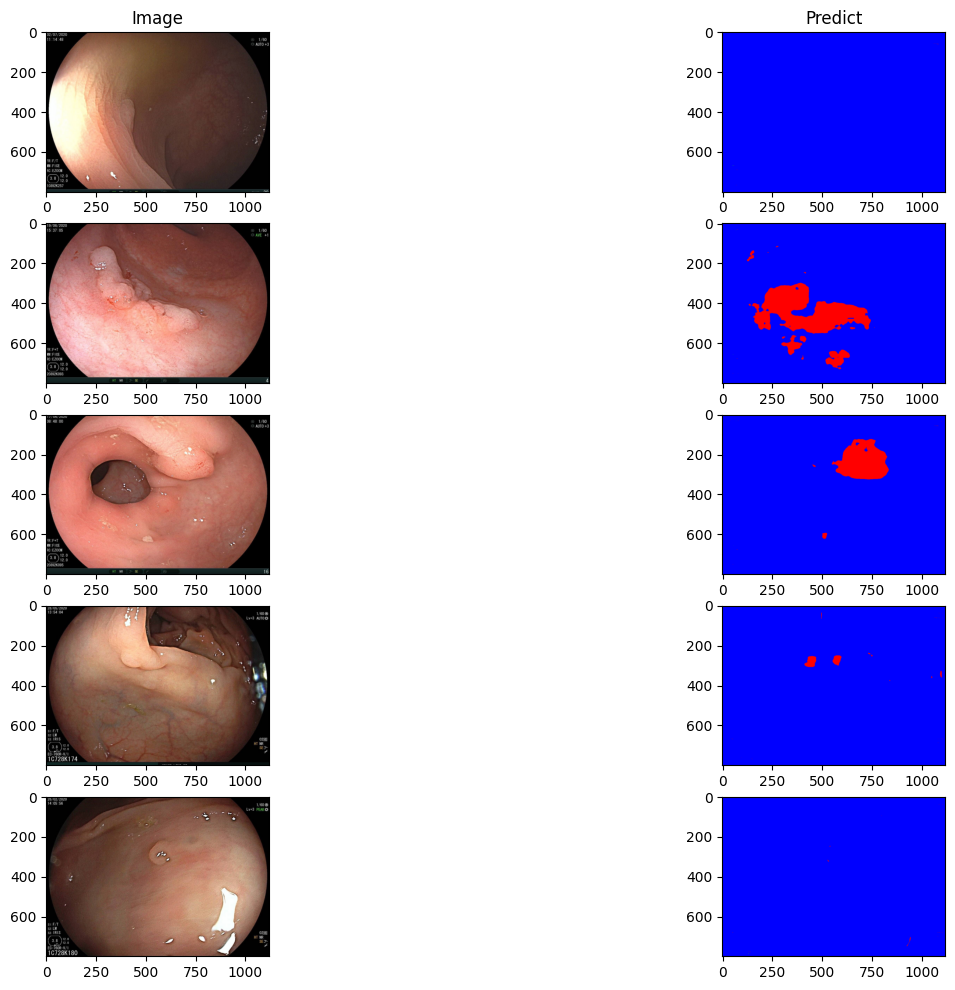

In [22]:
transform = Compose([Resize((800, 1120), interpolation=InterpolationMode.BILINEAR),
                     PILToTensor()])
class UNetTestDataClass(Dataset):
    def __init__(self, images_path, transform):
        super(UNetTestDataClass, self).__init__()
        
        images_list = os.listdir(images_path)
        images_list = [images_path+i for i in images_list]
        
        self.images_list = images_list
        self.transform = transform
        
    def __getitem__(self, index):
        img_path = self.images_list[index]
        data = Image.open(img_path)
        h = data.size[1]
        w = data.size[0]
        data = self.transform(data) / 255        
        return data, img_path, h, w
    
    def __len__(self):
        return len(self.images_list)
path = '/kaggle/input/bkai-igh-neopolyp/test/test/'
unet_test_dataset = UNetTestDataClass(path, transform)
test_dataloader = DataLoader(unet_test_dataset, batch_size=8, shuffle=True)
for i, (data, path, h, w) in enumerate(test_dataloader):
    img = data
    break
fig, arr = plt.subplots(5, 2, figsize=(16, 12))
arr[0][0].set_title('Image');
arr[0][1].set_title('Predict');

model.eval()
with torch.no_grad():
    predict = model(img)

for i in range(5):
    arr[i][0].imshow(img[i].permute(1, 2, 0));
    arr[i][1].imshow(F.one_hot(torch.argmax(predict[i], 0).cpu()).float())
model.eval()
if not os.path.isdir("/kaggle/working/predicted_masks"):
    os.mkdir("/kaggle/working/predicted_masks")
for _, (img, path, H, W) in enumerate(test_dataloader):
    a = path
    b = img
    h = H
    w = W
    
    with torch.no_grad():
        predicted_mask = model(b)
    for i in range(len(a)):
        image_id = a[i].split('/')[-1].split('.')[0]
        filename = image_id + ".png"
        mask2img = Resize((h[i].item(), w[i].item()), interpolation=InterpolationMode.NEAREST)(ToPILImage()(F.one_hot(torch.argmax(predicted_mask[i], 0)).permute(2, 0, 1).float()))
        mask2img.save(os.path.join("/kaggle/working/predicted_masks/", filename))
def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)

def rle_encode_one_mask(mask):
    pixels = mask.flatten()
    pixels[pixels > 0] = 255
    use_padding = False
    if pixels[0] or pixels[-1]:
        use_padding = True
        pixel_padded = np.zeros([len(pixels) + 2], dtype=pixels.dtype)
        pixel_padded[1:-1] = pixels
        pixels = pixel_padded
    
    rle = np.where(pixels[1:] != pixels[:-1])[0] + 2
    if use_padding:
        rle = rle - 1
    rle[1::2] = rle[1::2] - rle[:-1:2]
    return rle_to_string(rle)

def mask2string(dir):
    ## mask --> string
    strings = []
    ids = []
    ws, hs = [[] for i in range(2)]
    for image_id in os.listdir(dir):
        id = image_id.split('.')[0]
        path = os.path.join(dir, image_id)
        print(path)
        img = cv2.imread(path)[:,:,::-1]
        h, w = img.shape[0], img.shape[1]
        for channel in range(2):
            ws.append(w)
            hs.append(h)
            ids.append(f'{id}_{channel}')
            string = rle_encode_one_mask(img[:,:,channel])
            strings.append(string)
    r = {
        'ids': ids,
        'strings': strings,
    }
    return r
MASK_DIR_PATH = '/kaggle/working/predicted_masks' # change this to the path to your output mask folder
dir = MASK_DIR_PATH
res = mask2string(dir)
df = pd.DataFrame(columns=['Id', 'Expected'])
df['Id'] = res['ids']
df['Expected'] = res['strings']
df.to_csv(r'output.csv', index=False)